In [1]:
import os, importlib, numpy as np, copy
from sys import path

import matplotlib.pyplot as plt
from scipy.io import readsav
import astropy.units as u, astropy.wcs, astropy.io.fits
from sunpy.map import Map
from astropy.time import Time

path.append('../codebase')
from aia import iswat_map, estimate_aia_error_fromdat, aia_temperature_response
from dems import simple_reg_dem, estimate_uncertainty

In [2]:
data_keynames = 'amap94', 'amap131', 'amap171', 'amap193', 'amap335'
channels = 'AIA94_THIN', 'AIA131_THIN', 'AIA171_THIN', 'AIA193_THIN', 'AIA335_THIN'
outfile = '../save/radloss_iswat_042820.fits'
sav = readsav('../data/averaged_AIA.sav', python_dict=True)

In [3]:
maps = [iswat_map(sav,data_keynames[0])]
for i in range(1,len(data_keynames)):
	mapi = iswat_map(sav,data_keynames[i])
	maps.append(mapi.reproject_to(maps[0].wcs))
	maps[i].meta['EXPTIME'] = mapi.meta['EXPTIME']

In [4]:
tresps = []
nx, ny, nc = maps[0].data.shape[0], maps[0].data.shape[1], len(maps)
exptimes = np.zeros(nc)
errs = np.zeros([nx,ny,nc])
data = np.zeros([nx,ny,nc])
for i in range(0,nc):
	data[:,:,i] = maps[i].data
	exptimes[i] = maps[i].meta['EXPTIME']
	logt, tr = aia_temperature_response(None, channels[i])
	tresps.append(tr[(logt >= 4.74999)*(logt <= 7.25001)])
	errs[:,:,i] = np.clip(estimate_aia_error_fromdat(data[:,:,i], channels[i]),0.05*data[:,:,i],None)
logt = logt[(logt >= 4.74999)*(logt <= 7.25001)]
tresps = np.array(tresps).T

In [5]:
coeffs,chi2 = simple_reg_dem(data, errs, exptimes, logt, tresps)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [34]:
dem_errs = estimate_uncertainty(errs/exptimes, logt, tresps, dlogt=0.1)
coeffs_errsub = np.clip(coeffs-0.2*dem_errs,0,None)

arrays: dict_keys(['temperature', 'photo_loss_rate', 'coronal_loss_rate'])


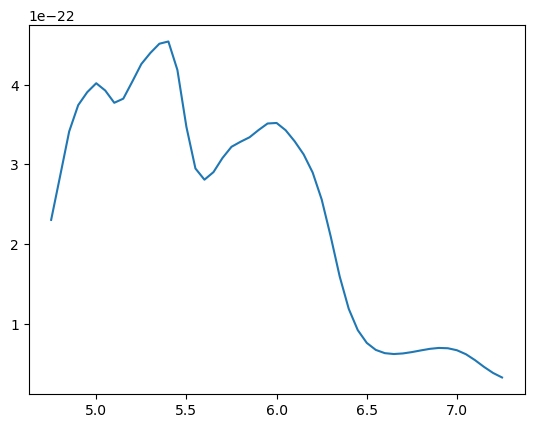

In [35]:
rldata = readsav('../data/rad_loss_arrays.sav')
print("arrays:", rldata.keys())
radloss = np.interp(logt,np.log10(rldata['temperature']),rldata['coronal_loss_rate'])
plt.plot(logt,radloss)

In [36]:
dlogt = logt[1]-logt[0]
synth_data = np.zeros(data.shape)
synth_data_errsub = np.zeros(data.shape)
synth_radloss = np.zeros([nx,ny])
synth_radloss_errsub = np.zeros([nx,ny])
from scipy.integrate import trapezoid
for i in range(0,nx):
	for j in range(0,ny):
		synth_radloss[i,j] = trapezoid(coeffs[i,j,:]*radloss)*dlogt
		synth_radloss_errsub[i,j] = trapezoid(coeffs_errsub[i,j,:]*radloss)*dlogt
		for k in range(0,nc):
			synth_data[i,j,k] = exptimes[k]*trapezoid(coeffs[i,j,:]*tresps[:,k])*dlogt
			synth_data_errsub[i,j,k] = exptimes[k]*trapezoid(coeffs_errsub[i,j,:]*tresps[:,k])*dlogt

[Text(0.5, 1.0, 'AIA 193 From DEMs with Error Subtraction')]

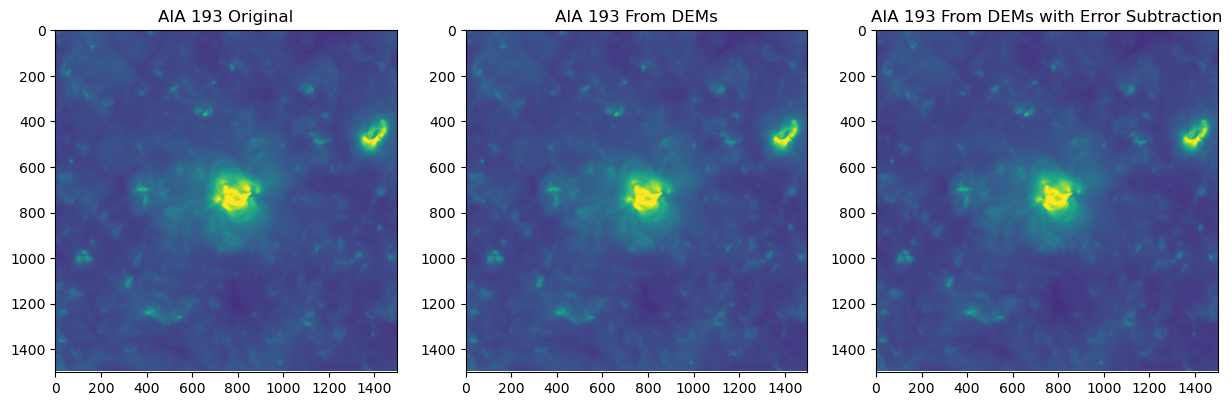

In [37]:
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=[15,5])
axes[0].imshow(data[:,:,3]**0.5,vmin=0,vmax=50000**0.5)
axes[0].set(title='AIA 193 Original')
axes[1].imshow(synth_data[:,:,3]**0.5,vmin=0,vmax=50000**0.5)
axes[1].set(title='AIA 193 From DEMs')
axes[2].imshow(synth_data_errsub[:,:,3]**0.5,vmin=0,vmax=50000**0.5)
axes[2].set(title='AIA 193 From DEMs with Error Subtraction')

[Text(0.5, 1.0, 'Radiative Loss From DEMs with Error Subtraction')]

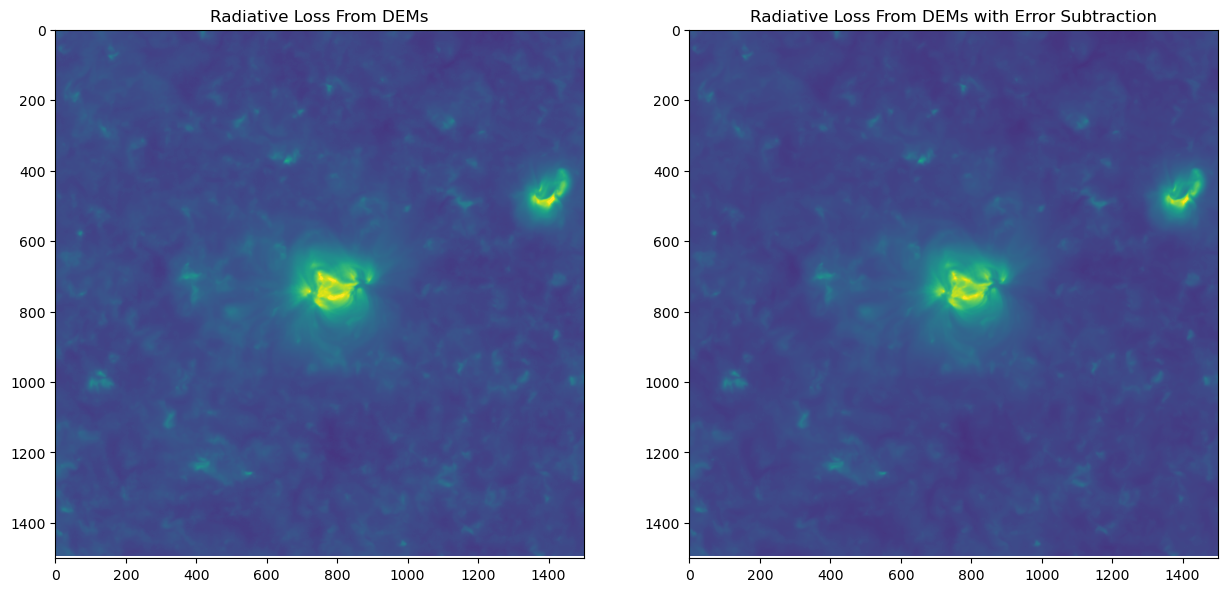

In [38]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=[15,7.5])
axes[0].imshow(synth_radloss**0.5,vmin=0,vmax=1.0e6**0.5)
axes[0].set(title='Radiative Loss From DEMs')
axes[1].imshow(synth_radloss_errsub**0.5,vmin=0,vmax=1.0e6**0.5)
axes[1].set(title='Radiative Loss From DEMs with Error Subtraction')

In [39]:
chi2s = np.nanmean((synth_data-data)**2/(errs)**2,axis=2)
chi2s_errsub = np.nanmean((synth_data_errsub-data)**2/(errs)**2,axis=2)

/tmp/ipykernel_269891/4199369095.py:1: RuntimeWarning: Mean of empty slice
  chi2s = np.nanmean((synth_data-data)**2/(errs)**2,axis=2)
/tmp/ipykernel_269891/4199369095.py:2: RuntimeWarning: Mean of empty slice
  chi2s_errsub = np.nanmean((synth_data_errsub-data)**2/(errs)**2,axis=2)


In [40]:
np.nanmean(chi2s), np.nanmean(chi2s_errsub)

(2.1705283636861727, 3.2928756776545303)

[Text(0.5, 1.0, 'Per Pixel $\\chi^2$ with Error Subtraction')]

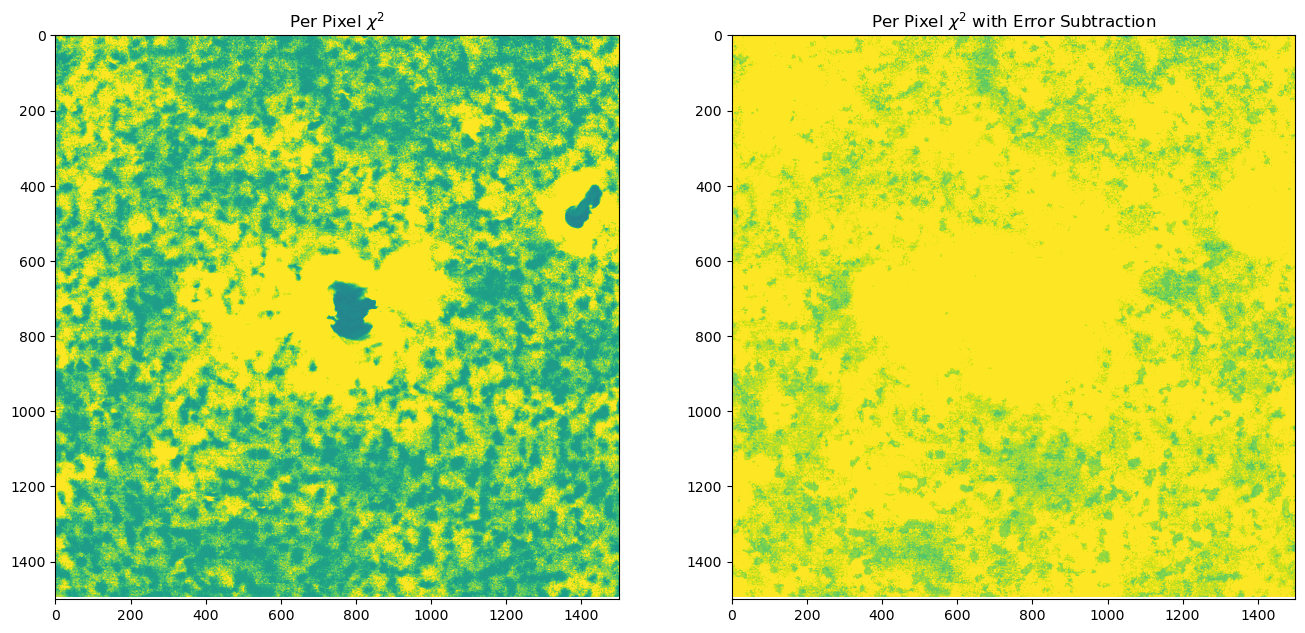

In [42]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=[16,8])
axes[0].imshow(chi2s**0.5,vmin=0,vmax=3**0.5)
axes[0].set(title=r'Per Pixel $\chi^2$')
axes[1].imshow(chi2s_errsub**0.5,vmin=0,vmax=3**0.5)
axes[1].set(title=r'Per Pixel $\chi^2$ with Error Subtraction')

In [43]:
radloss_map = copy.deepcopy(maps[0])
radloss_map.data[::] = synth_radloss_errsub
radloss_map.save(outfile,overwrite=True)

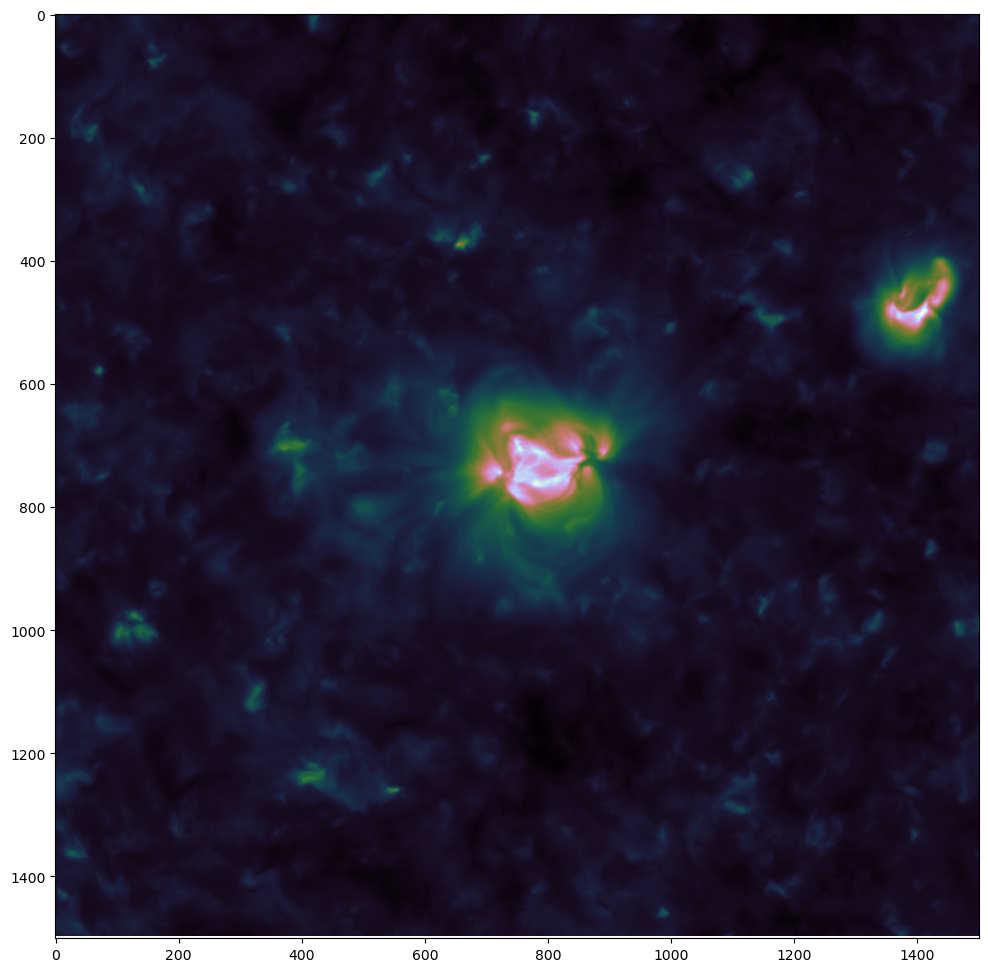

In [51]:
fig = plt.figure(figsize=[12,12])
plt.imshow(radloss_map.data**0.5, cmap=plt.get_cmap('cubehelix'))

In [53]:
np.nanmax(radloss_map.data)

1157519.1

In [54]:
np.nanmean(radloss_map.data)

56847.36

In [69]:
meancount_normed = 400
normfac = meancount_normed/np.nanmean(radloss_map.data)
# Error estimates for the reconstruction:
#err_map = copy.deepcopy(emis_config['map'])
#norm_factor = 10
#err_map.data[:,:] = err_map.data/normfac # norm. factor

#chan1_err = estimate_aia_error(err_map, channel='AIA335_THIN')*normfac


print(np.nanmean(radloss_map.data)*normfac, normfac)

400.0 0.007036386639550925


In [64]:
from astropy.io import fits
oldmap = '/home/jplowman/research/solar-physics/projects/nanoflares/will_files/data/A_Rate_Map.fits'

hdul = fits.open(oldmap)
radloss_dat_old, radloss_hdr_old = hdul[0].data, hdul[0].header
hdul.close()

In [66]:
np.nanmean(radloss_dat_old)/np.nanmean(radloss_map.data)

0.0352764381219505

In [ ]:
# Error estimates for the reconstruction:
meancount_normed = 400
err_map = copy.deepcopy(emis_config['map'])
normfac = 1/(meancount_normed/np.nanmean(err_map.data)) #norm_factor = 10
err_map.data[:,:] = err_map.data/normfac # norm. factor
chan1_err = estimate_aia_error(err_map, channel='AIA193_THIN')*normfac
data_corr = copy.deepcopy(emis_config['map'].data)
# Adjust reg_fac until final chi squared is about 1.75
solution = reconstruct(amat, emis_config, reg_fac=5.0e9, dat_xpo=1, errs=chan1_err, solver_tol=1.0e-5, data=data_corr, sqrmap=False, map_reg=False, regmat=regmat)